In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy import*
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# check columns from the two tables 
musr_columns = inspector.get_columns('Measurement')
for column in musr_columns:
    print(column["name"], column["type"])
print("-"*20)
st_columns = inspector.get_columns('Station')
for c in st_columns:
     print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
print(recent_date.date)

2017-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

most_recent_data = session.query(Measurement).order_by(Measurement.date.desc()).first()

print(f"The most recent data point: {most_recent_data.date}")
print('-'*50)


# Calculate the date one year from the last date in data set.
previous_yr = dt.date(2017, 8, 23) - dt.timedelta(days=365)

print(f"The date one year from the last date in data set: {previous_yr}")

The most recent data point: 2017-08-23
--------------------------------------------------
The date one year from the last date in data set: 2016-08-23


In [11]:
# Perform a query to retrieve the date and precipitation scores
measurement_columns = (Measurement.date,Measurement.prcp)

prcp_date = session.query(*measurement_columns).\
            filter(Measurement.date >= previous_yr).all()

prcp_date[:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_date, columns=['date','prcp'])
prcp_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [13]:
# Sort the dataframe by date
prcp_df.set_index('date', inplace=True)
prcp_df = prcp_df.sort_index()
#prcp_df.head()

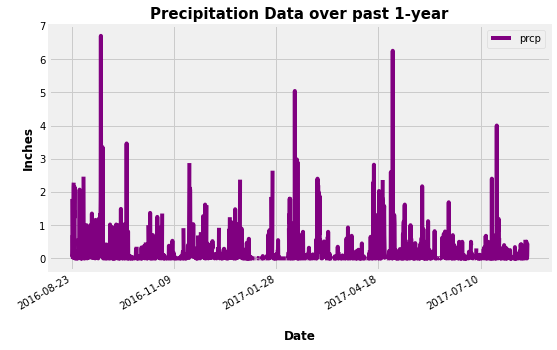

<Figure size 432x288 with 0 Axes>

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data

ax = prcp_df.plot(rot=30, color='purple', subplots=True, figsize=(8,5));

plt.title("Precipitation Data over past 1-year", weight="bold", size=15);
plt.xlabel("\nDate", weight="bold");
plt.ylabel("\nInches", weight="bold");
plt.show()

#plt.grid()
plt.tight_layout()

#plt.savefig("Images/Precipitations.png")

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
total_no_stations = session.query(func.count(Station.id)).all()
total_no_stations

[(9)]

In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()
active_stations      
# most_active_stations = pd.DataFrame(active_stations, columns=["Station", "Station_Count"])
# most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_st = active_stations[0][0]

select_query = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

most_active_st_tobs = session.query(*select_query).\
                    filter(Measurement.station==most_active_st).all()[0]

print(f'Lowest Temp. : {most_active_st_tobs[0]}')
print(f'Highest Temp. : {most_active_st_tobs[1]}')
print(f'Average Temp. : {most_active_st_tobs[2]}')

Lowest Temp. : 54.0
Highest Temp. : 85.0
Average Temp. : 71.66378066378067


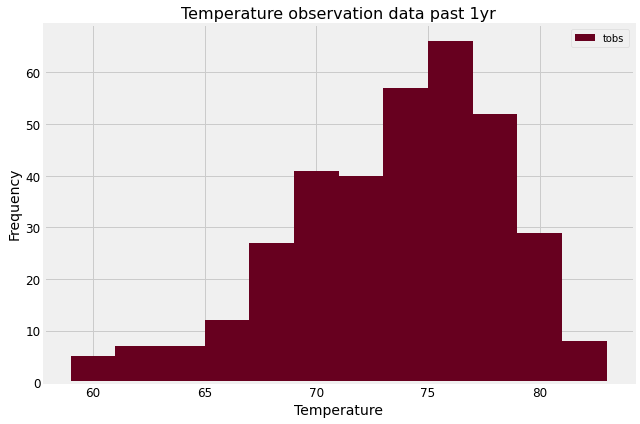

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_id = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station=='USC00519281').\
                    filter(Measurement.date > previous_yr).all()
        

# # Convert into DataFrame
active_station_id_df = pd.DataFrame(active_station_id)

active_station_id_df.plot(kind="hist", figsize=(9,6), bins=12, colormap="RdGy", legend=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title(f"Temperature observation data past 1yr", fontsize=16)

plt.tight_layout()
#plt.savefig("Images/Station-histogram.png")
plt.show()


# Bonus: Temperature Analysis I

In [20]:
# "tobs" is "temperature observations"
df = pd.read_csv('Resources/hawaii_measurements.csv')
df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [21]:
# Convert the date column format from string to datetime

results = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).all()
temp_df = pd.DataFrame(results)
temp_df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65.0
1,USC00519397,2010-01-02,0.00,63.0
2,USC00519397,2010-01-03,0.00,74.0
3,USC00519397,2010-01-04,0.00,76.0
4,USC00519397,2010-01-06,NaN,73.0


In [22]:
# Set the date column as the DataFrame index
temp_df['date'] = pd.to_datetime(temp_df['date'], infer_datetime_format=True)
temp_df = temp_df.set_index('date')
temp_df.head()


,station,prcp,tobs
date,,,
2010-01-01,USC00519397,0.08,65.0
2010-01-02,USC00519397,0.00,63.0
2010-01-03,USC00519397,0.00,74.0
2010-01-04,USC00519397,0.00,76.0
2010-01-06,USC00519397,NaN,73.0


In [23]:
# Drop the date column

### Compare June and December data across all years

In [24]:
from scipy import stats

In [25]:
# Filter data for desired months i.e June and December date and temerature

#For June :
june_temp = session.query(Measurement.date, Measurement.tobs).\
            filter(extract('month', Measurement.date) == '06')
    
june_df = pd.DataFrame(june_temp, columns=['Date', 'Temp'])
june_df.head()

,Date,Temp
0,2010-06-01,78.0
1,2010-06-02,76.0
2,2010-06-03,78.0
3,2010-06-04,76.0
4,2010-06-05,77.0


In [26]:
#For December:
dec_temp = session.query(Measurement.date, Measurement.tobs).\
            filter(extract('month', Measurement.date)=='12')
    
dec_df = pd.DataFrame(dec_temp, columns=['Date', 'Temp'])
dec_df.head()

,Date,Temp
0,2010-12-01,76.0
1,2010-12-03,74.0
2,2010-12-04,74.0
3,2010-12-06,64.0
4,2010-12-07,64.0


In [27]:
# Identify the average temperature for June and December.
june_avg_temp = june_df['Temp'].mean()
dec_avg_temp = dec_df['Temp'].mean()

print(f'Average temperature for June :{june_avg_temp}')
print('-'*50)
print(f'Average temperature for December :{dec_avg_temp}')

Average temperature for June :74.94411764705882
--------------------------------------------------
Average temperature for December :71.04152933421226


In [28]:
# Create collections of temperature data
june_temp = june_df['Temp']
dec_temp = dec_df['Temp']
june_temp

0       78.0
1       76.0
2       78.0
3       76.0
4       77.0
        ... 
1695    79.0
1696    74.0
1697    74.0
1698    76.0
1699    75.0
Name: Temp, Length: 1700, dtype: float64

In [29]:
# Run paired t-test

stats.ttest_ind(june_temp, dec_temp)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

###### Analysis

## Bonus Challenge Assignment: Temperature Analysis II
    

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set From "2017-08-01" to "2017-08-07"

# Start and end date
start_dt = '2017-08-01'
end_dt = '2017-08-07'

# Convert string date into date format
start_date = (dt.datetime.strptime(start_dt, "%Y-%m-%d")).date()
end_date = (dt.datetime.strptime(end_dt, "%Y-%m-%d")).date()

def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


temps = calc_temps('2017-08-01', '2017-08-07')
tmin = temps[0][0]
tavg = round(temps[0][1], 2)
tmax = temps[0][2]


# temperature info 
print(f"Vacation start date: {start_date}")
print(f"Vacation end date: {end_date}")

print("----------------------------------------------------------------")

print(f"Minimum temp: {tmin} | Average temp: {tavg} | Max temp: {tmax}")

Vacation start date: 2017-08-01
Vacation end date: 2017-08-07
----------------------------------------------------------------
Minimum temp: 72.0 | Average temp: 79.25 | Max temp: 83.0


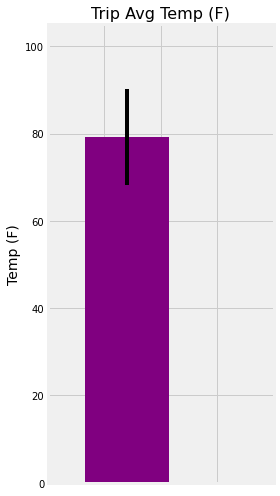

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
#-----------------------------------------------------------------------#

# Y error bar value (tmax-tmin)
yerror = tmax-tmin

# Bar chart for above query results:
plt.figure(figsize = (4,7))
plt.bar(1.1, height=tavg, yerr=yerror, width = 1.5, color='purple', alpha = 1,  align='center')
xaxis_values = np.arange(-0.3,3.8, step=1)
plt.title("Trip Avg Temp (F)", fontsize = 16)
plt.ylabel("Temp (F)", fontsize=14)
plt.ylim(0,105)
plt.xticks(xaxis_values, "")

plt.tight_layout()
#plt.savefig("Images/TripAvgTemp.png")
plt.show()

### Daily Rainfall Average

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_start_dt = '2017-08-01'
trip_end_dt = '2017-08-07'

rain_station = (
    session.query(
        Station.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        func.avg(Measurement.prcp),
    )
    .filter(
        Measurement.station == Station.station,
        Measurement.date.between(trip_start_dt, trip_end_dt),
    )
    .group_by(Station.station)
    .order_by(func.avg(Measurement.prcp).desc())
    .all()
)

# Convert query object to data frame
rain_station_df = pd.DataFrame(np.array(rain_station))
rain_station_df = rain_station_df.rename(
    columns={
        0: "Station",
        1: "Location",
        2: "Lat",
        3: "Long",
        4: "Elevation",
        5: "Total_Prcp"
    }
)

rain_station_df


,Station,Location,Lat,Long,Elevation,Total_Prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,0.12
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,0.03666666666666667
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9,0.02
3,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.005714285714285714
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.0


In [34]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = (dt.datetime.strptime('2017-08-01', "%Y-%m-%d")).date()
end_date = (dt.datetime.strptime('2017-08-07', "%Y-%m-%d")).date()


# Use the start and end date to create a range of dates
trip_dates = []

# Taking cuttent_date variable so that actual start_date remain unchanged
current_date = start_date


# Strip off the year and save a list of strings in the format %m-%d
while current_date <= end_date:
    month = current_date.strftime("%m")
    day = current_date.strftime("%d")
    trip_dates.append(f'{month}-{day}')
    current_date += dt.timedelta(days=1)

    
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []

for i in range(len(trip_dates)):
    day_normal = daily_normals(trip_dates[i])
    normals.append(day_normal[0])
    
#normals

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(normals, columns=['Temp_Min (F)', 'Temp_Avg (F)', 'Temp_Max (F)'])
daily_normals_df['Date'] = trip_dates
daily_normals_df.set_index('Date')

,Temp_Min (F),Temp_Avg (F),Temp_Max (F)
Date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


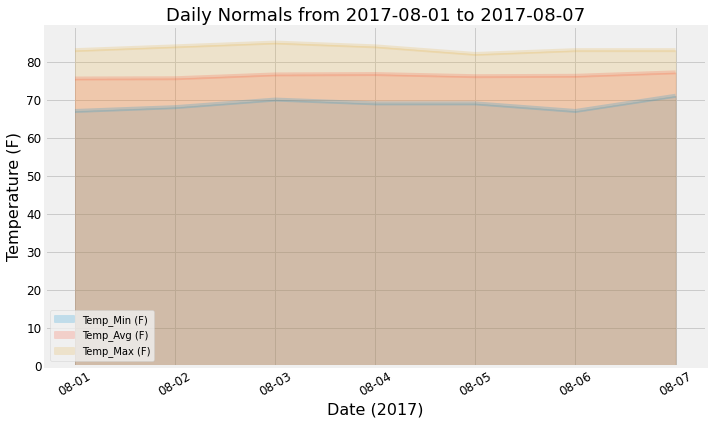

In [37]:
# Plot the daily normals as an area plot with `stacked=False`

daily_normals_df.plot.area(figsize=(10,6), stacked=False, alpha = 0.2, rot=30, fontsize=12)

plt.xticks(np.arange(len(trip_dates)), labels=trip_dates)

plt.title(f"Daily Normals from {start_date} to {end_date}", fontsize=18)
plt.xlabel("Date (2017)", fontsize=16)
plt.ylabel("Temperature (F)", fontsize=16)

plt.tight_layout()
#plt.savefig("Images/dailynormals.png")
plt.show()

# Close session

In [38]:
# Close Session
session.close()